In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
from time import time
import json
import pickle
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
with open('./flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt') as f:
    captions = f.read()

In [3]:
captions = captions.split("\n")[:-1]

In [4]:
len(captions)

40460

In [5]:
description = {}
for elem in captions:
    i_to_c = elem.split("\t")
    cap = i_to_c[1]
    key = i_to_c[0].split(".")[0]
    if(description.get(key)==None):
        description[key] = []
    description[key].append(cap)

In [6]:
description["12830823_87d2654e31"]

['Children sit and watch the fish moving in the pond',
 'people stare at the orange fish .',
 'Several people are standing near a fish pond .',
 'Some children watching fish in a pool .',
 'There are several people and children looking into water with a blue tiled floor and goldfish .']

## Data Cleaning

In [7]:
"""
1. Lower
2. remove punctuations
3. remove words less than len 2
"""
def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1] # Step 3
    sample = " ".join(sample)
    return sample
    

In [8]:
clean_text("Virat Kohli is67890 4232@1./ a India-Cricket Team captain.......")

'virat kohli is india cricket team captain'

In [9]:
for key,desc_list in description.items():
    for i in range(len(desc_list)):
        description[key][i] = clean_text(desc_list[i])

In [10]:
description["12830823_87d2654e31"]

['children sit and watch the fish moving in the pond',
 'people stare at the orange fish',
 'several people are standing near fish pond',
 'some children watching fish in pool',
 'there are several people and children looking into water with blue tiled floor and goldfish']

In [11]:
# Create Unique Vocabulary
vocabulary = set()

for key in description.keys():
    [vocabulary.update(i.split()) for i in description[key]]
print("Vocabulary size : %d"% len(vocabulary))

Vocabulary size : 8424


In [12]:
all_vocab = []

for key in description.keys():
    [all_vocab.append(i) for des in description[key] for i in des.split()]
    
print("All Vocab : ",len(all_vocab))


All Vocab :  373837


In [13]:
import collections

In [14]:
counter = collections.Counter(all_vocab)

In [15]:
dict_ = dict(counter)

In [16]:
sorted_dict = sorted(dict_.items(),reverse = True,key = lambda x:x[1])

In [17]:
threshold_val = 10
sorted_dict = [x for x in sorted_dict if x[1]>threshold_val]
vocabulary = [x[0] for x in sorted_dict]

In [18]:
len(vocabulary)

1845

## Load Training Testing Data

In [19]:
with open("flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as f:
    train = f.read()
with open("flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
    test = f.read()

In [20]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [21]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    for cap in description[t]:
        cap_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_append)
        

In [22]:
train_descriptions["667626_18933d713e"]

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq young girl is lying in the sand while ocean water is surrounding her endseq',
 'startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq']

## Data Preprocessing

In [23]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [24]:
"""
Load out all Images and do some preprocess so that we can feed it in our network
"""


'\nLoad out all Images and do some preprocess so that we can feed it in our network\n'

In [25]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

In [26]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [27]:
# model.layers[-2].output

In [28]:
from keras.models import Model

In [29]:
model_new = Model(inputs = model.input,outputs=model.layers[-2].output)

In [30]:
def preprocess_image(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    ## Expanding dimension as img goes in batches inside model => (1,224,224,3)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    
    return img
    

In [31]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img).reshape((2048,))
    return feature_vector

In [32]:
x = encode_image("./flickr8k/Flickr_Data/Flickr_Data/Images/1002674143_1b742ab4b8.jpg")

In [33]:
x.shape

(2048,)

In [ ]:
start = time()
encoding_train = {}
images = "./flickr8k/Flickr_Data/Flickr_Data/Images/"
for ix,img_t in enumerate(train):
    img = images + img_t + ".jpg"
    encoding_train[img] = encode_image(img)
#     encoding_train[img(len(images):)] = encode_image(img)
    if ix%100==0:
        print("encoding image " + str(ix),end="\r")
# print("Time is: "+ time()-start)

In [ ]:
# Writing pkl file on disk
with open("encoded_train_images.pkl","wb") as p:
    pickle.dump(encoding_train,p)

In [34]:
# Reading pkl file from disk
with open("./Encoding_Data/encoded_train_images.pkl","rb") as p:
    encoding_train = pickle.load(p)

In [ ]:
start = time()
encoding_test = {}
images = "./flickr8k/Flickr_Data/Flickr_Data/Images/"
for ix,img_t in enumerate(test):
    img = images + img_t + ".jpg"
    encoding_test[img] = encode_image(img)
#     encoding_train[img(len(images):)] = encode_image(img)
    if ix%100==0:
        print("encoding image " + str(ix),end="\r")
# print("Time is: "+ str(time()-start))

In [ ]:
# Writing pkl file on disk
with open("encoded_test_images.pkl","wb") as p:
    pickle.dump(encoding_test,p)

In [35]:
# Reading pkl file from disk
with open("./Encoding_Data/encoded_test_images.pkl","rb") as p:
    encoding_test = pickle.load(p)

## Data Preprocessing- Captions

In [36]:
# Mapping Word to Index and index to word
ix = 1
word_to_idx = {}
idx_to_word = {}

for e in vocabulary:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix += 1
    
    

In [37]:
word_to_idx['dog']

6

In [38]:
idx_to_word[6]

'dog'

In [39]:
# Special Word
idx_to_word[1846] = "startseq"
word_to_idx['startseq'] = 1846

idx_to_word[1847] = "endseq"
word_to_idx['endseq'] = 1847

In [40]:
vocabulary_size = len(idx_to_word) + 1
print(vocabulary_size)

1848


In [41]:
all_caption_len = []
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))
max_len = max(all_caption_len)
print(max_len)

35


## Data Prepare using Generator

In [73]:
images = "./flickr8k/Flickr_Data/Flickr_Data/Images/"

In [76]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):  
    n = 0
    X1,X2,y = [],[],[]
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[images + key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding='post')[0]
                    out_seq = to_categorical([out_seq],num_classes=vocabulary_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[np.array(X1),np.array(X2)],np.array(y)]
                n = 0
                X1,X2,y = [],[],[]
                

# Word Embedding

In [77]:
with open("./glove.6B.50d.txt",encoding="utf8") as f:
    embedding_index={}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype="float")
        embedding_index[word] = coefs

In [78]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [79]:
def get_embedding_output():
    em_dim = 50
    embedding_output = np.zeros((vocabulary_size,em_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    return embedding_output

In [80]:
embedding_output = get_embedding_output()

In [81]:
embedding_output.shape

(1848, 50)

In [82]:
print(embedding_output)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.33042   0.24995  -0.60874  ... -0.50703  -0.027273 -0.53285 ]
 [ 0.418     0.24968  -0.41242  ... -0.18411  -0.11514  -0.78581 ]
 ...
 [-0.34126  -0.06117   0.93339  ... -0.5682   -0.6244    0.30874 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


## Model Architecture

In [83]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [84]:
# Image feature extractor model
input_img_feature = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_feature)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [85]:
# Partial Caption Sequence Model
input_caption = Input(shape=(max_len,))
input_caption1 = Embedding(input_dim=vocabulary_size,output_dim=50,mask_zero=True)(input_caption)
input_caption2 = Dropout(0.3)(input_caption1)
input_caption3 = LSTM(256)(input_caption2)

In [86]:
# Combining both models

decoder = add([inp_img2,input_caption3])
decoder1 = Dense(256,activation='relu')(decoder)
output = Dense(vocabulary_size,activation='softmax')(decoder1)

In [87]:
model = Model(inputs = [input_img_feature,input_caption],outputs = output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [88]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [89]:
model.compile(loss='categorical_crossentropy',optimizer='adam')


## Training

In [90]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [101]:
for i in range(10):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save("./model_"+str(i)+".h5")

Epoch 1/1
2000/2000 [==============================] - 356s 178ms/step - loss: 2.6395
Epoch 1/1
2000/2000 [==============================] - 341s 170ms/step - loss: 2.6147
Epoch 1/1
2000/2000 [==============================] - 340s 170ms/step - loss: 2.5965
Epoch 1/1
2000/2000 [==============================] - 340s 170ms/step - loss: 2.5785
Epoch 1/1
2000/2000 [==============================] - 344s 172ms/step - loss: 2.5610
Epoch 1/1
2000/2000 [==============================] - 350s 175ms/step - loss: 2.5444
Epoch 1/1
2000/2000 [==============================] - 376s 188ms/step - loss: 2.5330
Epoch 1/1
  14/2000 [..............................] - ETA: 6:19 - loss: 2.4792

KeyboardInterrupt: 

## Predictions

In [102]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += " "+word
        if word == "endseq":
            break
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
        
    return final_caption

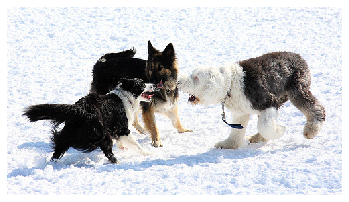

two dogs are playing in the snow


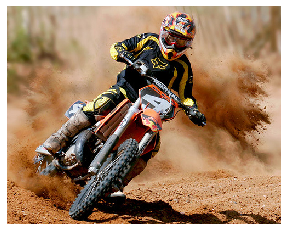

man in black helmet and helmet is racing bike


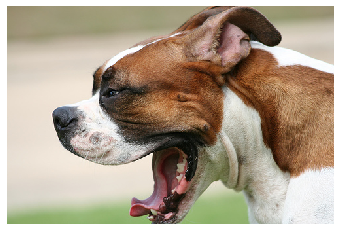

dog with its nose sticking is licking its nose


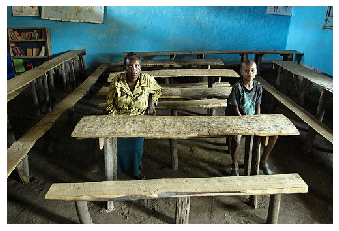

man sits on bench and reads book


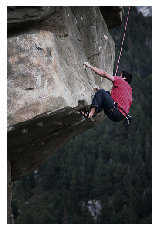

man is climbing up rock face


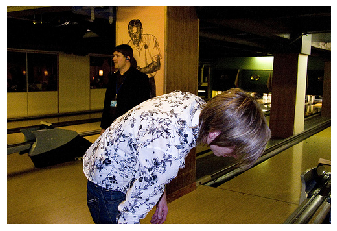

man in red shirt and jeans sits in front of computer


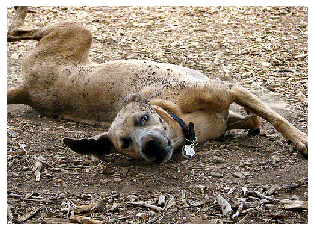

two dogs are bending in the air


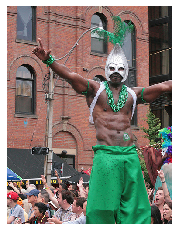

two men in red jerseys are playing with referee


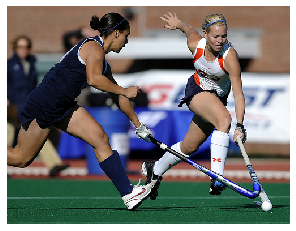

man in black shirt and black shorts is running


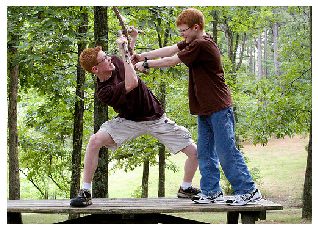

girl in pink shirt is walking on the path of wooden fence


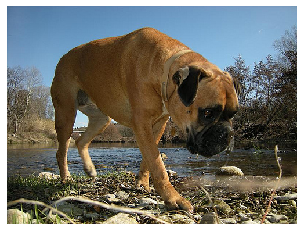

brown dog is running through the grass


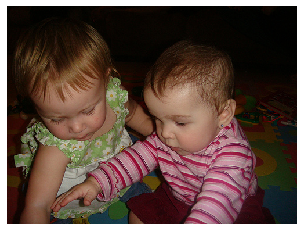

little girl in pajamas is holding her arms wrapped in her hand


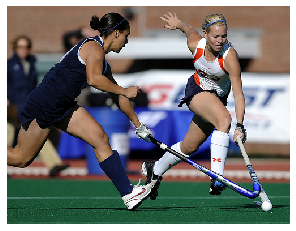

man in black shirt and black shorts is running


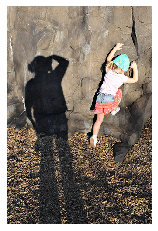

man in red shirt is standing on the grass


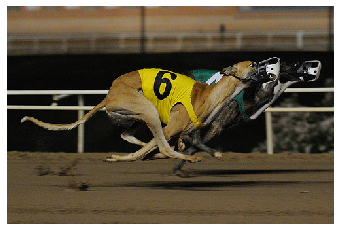

greyhound dog is running around track


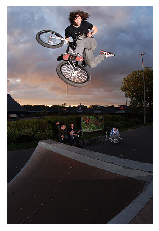

man doing skateboard trick on his skateboard


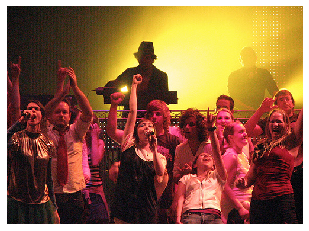

crowd of people surrounding crowd of people


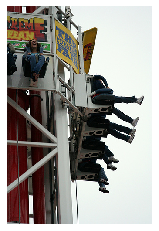

man in red shirt and hat is standing next to woman in red jacket


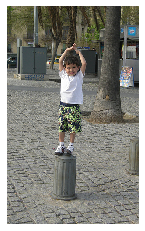

man and woman sitting on bench in front of lake


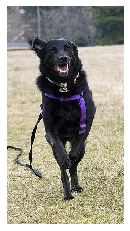

black dog running with toy in its mouth


In [104]:
for i in range(20):
    rn = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))
    i = plt.imread(img_name)
    plt.imshow(i)
    plt.axis('off')
    plt.show()

    caption = predict_caption(photo)
    print(caption)